# Kinetikus gázmodell szimulációja

## Feladatkitűzés

A *kinetikus gázelmélet* egyike a legegyszerűbb modelleknek, melynek segítségével a gázok termo- és hidrodinamikai viselkedése leírható. Segítségével a gázok legfőbb *makroszkópikus jellemzői* megmagyarázhatóak, így például a *nyomás, térfogat, hőmérséklet*, vagy éppenséggel a *viszkozitás* és a *diffúzió*. 

Az **ideális gáz**t definiáljuk mint, nagyszámú, apró, gyorsmozgású golyók halmaza, melyek rendezetlen mozgásukkal - egymással és a tárolóedény falával rugalmasan ütközve - kitöltik a rendelkezésükre álló teret.

**Az ideális gázok modellje**:
- A részecskék száma kellően nagy ahhoz, hogy a *statisztikai leírás indokolt legyen* és a részecskék által kitöltött térfogat *homogén hőmérsékleteloszlású* legyen. `Sok... `
- Az ideális gáz részecskéi *nagyon kicsik*. Azaz a részecskék össztérfogata elhanyagolható a tárolóedény űrtartalmához képest. `...pici... `
- A gyorsmozgású részecskék egymással és az edény falával is folyamatosan, *pillanatszerűen és rugalmasan ütköznek*. Így a részecskéket modellezhetjük tökéletesen tömör gömbökként. `...piros pont száguldozik és ütközik... `
- Az ütközéseket leszámítva, a részecskék közti egyéb kölcsönhatásoktól eltekintünk. `...és kész.`

Rugalmas ütközés során, könnyen belátható, hogy az alábbiak szerint alakulnak az ütközés utáni sebeségek:
$\begin{equation} \mathbf{u}_1 = \mathbf{v}_1 - \frac{(\mathbf{v}_1-\mathbf{v}_2)\cdot(\mathbf{r}_1-\mathbf{r}_2)}{|\mathbf{r}_1-\mathbf{r}_2|^2}\cdot(\mathbf{r}_1-\mathbf{r}_2) \tag{1.1}\end{equation}$
$\begin{equation} \mathbf{u}_2 = \mathbf{v}_2 - \frac{(\mathbf{v}_2-\mathbf{v}_1)\cdot(\mathbf{r}_2-\mathbf{r}_1)}{|\mathbf{r}_1-\mathbf{r}_2|^2}\cdot(\mathbf{r}_2-\mathbf{r}_1) \tag{1.2}\end{equation}$
Ahol:
- $\mathbf{r}_i\in\mathbb{R}^2$ az $i$. indexű részecske helye
- $\mathbf{v}_i\in\mathbb{R}^2$ az $i$. indexű részecske sebessége az ütközés előtt
- $\mathbf{u}_i\in\mathbb{R}^2$ az $i$. indexű részecske sebessége az ütközés után

Feladatunk a modell elkészítése és vizualizációja `Matplotlib` library segítségével:
<p align="center">
  <img src="output.png?" width="400" />
</p>

## Megoldás

### Szükséges importok a feladatmegoldáshoz

In [11]:
import numpy as np                              # Alapvető matematikai eszköztár
import matplotlib.pyplot as plt                 # Plotoláshoz
import matplotlib                   
from matplotlib import animation                # Animációk készítéséhez
from matplotlib.animation import PillowWriter   # .gif formátumba való exportáláshoz
from itertools import combinations

### Kezdeti paraméterek inicializálása

Minden fizikai szimuláció kezdetekor **inicializáljuk az összes szükséges paramétert**! A kulcsmondat: `Sok, pici, piros pont száguldozik és ütközik és kész.` Azaz definiáljuk a részecskék számát, a részecskék méretét, emellett a helyét és a sebességét is!

Random számokat (egyenletes eloszlás alapján) az `np.random.random()` függvény segítségével tudunk generálni. Fontos, hogy ez a függvény $0$ és $1$ között egy *valós számot* generál! Az `np.random.uniform()` segítségével tetszőleges intervallumon tudunk random számokat generálni.

*<span style="color:teal">Megjegyzés: a kódolás elején célszerű inkább kevesebb és nagyobb pontot tekinteni! Több ezer pont esetén több 10 percet is igénybevehet a szimuláció lefutása, ez pedig nagyban megnehezíti a debuggolást!</span>* 

In [12]:
# Az adatok definiálása
N = 100                 # Részecskék száma
radius = 0.05           # Részecskék sugara

# Helyvektorok (R^2) inicializálása
r = np.random.random((2, N))                # N db R^2-beli vektor

# Sebességvektorok (R^2) inicializálása
v = np.random.uniform(-500, 500, (2,N))     # N db R^2-beli vektor

# Felcímkézzük az egyes pontokat
IDs = np.arange(N)

Ezt követően ábrázoljuk a kezdeti állapotot!

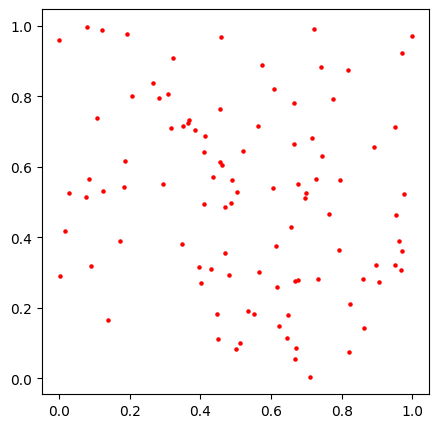

In [13]:
# Kezdeti állapot megjelenítése
plt.figure(figsize=(5,5))
plt.scatter(r[0],r[1], color='r', s=5)

plt.show()

### Ütközések szimulációja

A `Sok, pici, piros pont száguldozik és ütközik és kész.` kulcsmondat `Sok, pici, piros pont száguldozik` részét már sikeresen teljesítettük! Most pedig jöhet az `ütközik`, ami már egy fokkal bonyolultabb lépésekből áll.

Járjunk el a következő módon:
- **1. lépés**: Határozzuk meg az összes pontpár közti távolságot!
$$ d = \sqrt{\Delta x^2 + \Delta y^2}$$
- **2. lépés**: Ha $d < 2r$, akkor a rugalmas ütközés egyenletei alapján kiszámoljuk az új sebességeket.
- **3. lépés**: Ha a tárolóedény falával ütközik a részecske, akkor a falra merőleges sebességkomponens előjelet vált.

Így már tudjuk modellezni a mozgást!

#### 1. lépés: Pontpárok távolságának meghatározása

<p align="center">
  <img src="maneuver.png?" width="400" />
</p>

Páronként minden pont távolságát meg kell vizsgálnunk ahhoz, hogy eldöntsük, mely részecskék fognak ütközni. Ebben most mélyedjünk el egy pillanatra: $N=100$ pont esetén ez $100\cdot 99/2 = 4950$ távolságot definiál, $N=1000$ pontra ez már $499.500$ párt jelent! Tehát amíg $10$-szeresére növeltük a részecskék számát, a vizsgálandó párok száma $100$-szeresére, azaz $10^2$-szeresére nőtt!

A Computer Science nyelvén azt mondjuk, hogy ezen algoritmus komplexitása $\mathcal O(n^2)$ (ordó n-négyzetes, vagy kvadratikus idejű). Az $\mathcal O(n^2)$ komplexitás egyébként kimondottan rossz, és lassú futást eredményez nagy $N$ esetén. 

Az algoritmuselméletben az alábbi komplexitásokkal találkozhatunk gyakran:
- Gyors futási idő: $\mathcal O(1)$, $\mathcal O(\log n)$, $\mathcal O(\sqrt{n})$
- Közepes futási idő: $\mathcal O(n)$, $\mathcal O(n\log n)$
- Lassú futási idő: $\mathcal O(n^2)$, $\mathcal O(n^3)$, $\mathcal O(2^n)$, $\mathcal O(n!)$

In [14]:
# Felírjuk az összes párosítást
particlePairs = np.asarray(list(combinations(IDs,2)))
print(particlePairs)

# Felírjuk az egyes pontok x és y koordinátáit
xPairs = np.array([r[0][particlePairs[:,0]], r[0][particlePairs[:,1]]]).T
yPairs = np.array([r[1][particlePairs[:,0]], r[1][particlePairs[:,1]]]).T
print(xPairs)

# Kiszámítjuk x és y irányban az eltéréseket
ΔxPairs = np.diff(xPairs, axis=1).ravel()
ΔyPairs = np.diff(yPairs, axis=1).ravel()

# Ezt követően Pitagorasz-tétellel adódik a távolság
dPairs = np.sqrt(ΔxPairs**2 + ΔyPairs**2)

[[ 0  1]
 [ 0  2]
 [ 0  3]
 ...
 [97 98]
 [97 99]
 [98 99]]
[[0.01613758 0.5105771 ]
 [0.01613758 0.57419694]
 [0.01613758 0.69803031]
 ...
 [0.66751287 0.86348873]
 [0.66751287 0.38388185]
 [0.86348873 0.38388185]]


#### 2. lépés: Ütközések modellezése

Feltételezzük, hogy azon részecskék fognak ütközni, melyek távolsága kisebb, mint $2r$, amikor már a részecskék egymásban lennének. A kinetikus gázmodellben feltételezzük az *energia-*, *lendület-* és *perdületmegmaradás*t, ezért a gázrészecskék között **pillanatszerű, rugalmas ütközés**t teszünk fel. 

Rugalmas ütközés során, könnyen belátható, hogy az alábbiak szerint alakulnak az ütközés utáni sebeségek:
$\begin{equation} \mathbf{u}_1 = \mathbf{v}_1 - \frac{(\mathbf{v}_1-\mathbf{v}_2)\cdot(\mathbf{r}_1-\mathbf{r}_2)}{|\mathbf{r}_1-\mathbf{r}_2|^2}\cdot(\mathbf{r}_1-\mathbf{r}_2) \tag{1.1}\end{equation}$
$\begin{equation} \mathbf{u}_2 = \mathbf{v}_2 - \frac{(\mathbf{v}_2-\mathbf{v}_1)\cdot(\mathbf{r}_2-\mathbf{r}_1)}{|\mathbf{r}_1-\mathbf{r}_2|^2}\cdot(\mathbf{r}_2-\mathbf{r}_1) \tag{1.2}\end{equation}$
Ahol:
- $\mathbf{r}_i$ az $i$. indexű részecske helye
- $\mathbf{v}_i$ az $i$. indexű részecske sebessége az ütközés előtt
- $\mathbf{u}_i$ az $i$. indexű részecske sebessége az ütközés után

In [15]:
# Ütköző párok meghatározása
collidePairs = particlePairs[dPairs < 2*radius]
print(collidePairs)

# Sebességek definiálása
v1 = v[:, collidePairs[:,0]]
v2 = v[:, collidePairs[:,1]]

# Helyvektorok definiálása
r1 = r[:, collidePairs[:,0]]
r2 = r[:, collidePairs[:,1]]

# Az új sebességek
u1 = v1 - ((v1-v2)*(r1-r2)).sum(axis=0)/np.sum((r1-r2)**2, axis=0) * (r1-r2) 
u2 = v2 - ((v2-v1)*(r2-r1)).sum(axis=0)/np.sum((r1-r2)**2, axis=0) * (r2-r1) 

[[ 1  6]
 [ 1  9]
 [ 1 26]
 [ 1 29]
 [ 2 54]
 [ 3 12]
 [ 3 22]
 [ 3 43]
 [ 3 50]
 [ 3 86]
 [ 4 16]
 [ 4 25]
 [ 4 34]
 [ 4 55]
 [ 4 79]
 [ 4 81]
 [ 4 96]
 [ 5 33]
 [ 5 36]
 [ 5 69]
 [ 6 29]
 [ 6 37]
 [ 7 23]
 [ 8 95]
 [ 9 15]
 [ 9 26]
 [ 9 94]
 [10 68]
 [11 19]
 [11 39]
 [11 57]
 [11 75]
 [11 82]
 [11 89]
 [11 99]
 [12 86]
 [13 71]
 [13 77]
 [13 90]
 [13 93]
 [14 75]
 [14 82]
 [14 95]
 [15 26]
 [15 27]
 [15 70]
 [15 94]
 [16 25]
 [16 34]
 [16 67]
 [16 79]
 [17 31]
 [17 41]
 [17 43]
 [17 80]
 [18 51]
 [18 63]
 [18 71]
 [18 90]
 [18 93]
 [19 39]
 [19 46]
 [19 57]
 [19 89]
 [19 99]
 [21 44]
 [21 49]
 [21 84]
 [21 87]
 [22 50]
 [22 86]
 [24 30]
 [24 56]
 [25 34]
 [25 46]
 [25 67]
 [25 79]
 [25 81]
 [25 96]
 [26 37]
 [27 70]
 [27 94]
 [27 97]
 [28 54]
 [30 56]
 [31 41]
 [33 36]
 [33 69]
 [34 67]
 [34 79]
 [34 81]
 [34 96]
 [35 51]
 [36 69]
 [37 84]
 [38 42]
 [38 78]
 [38 87]
 [39 46]
 [39 57]
 [39 81]
 [39 89]
 [39 92]
 [39 96]
 [39 99]
 [40 53]
 [40 60]
 [42 88]
 [43 50]
 [43 80]
 [43 86]
 

#### Segéd lépés: Eddigiek összefoglalása függvényekbe

In [16]:
def Δxy_pairs(x, particle_pairs):
    return np.diff(np.array([x[particle_pairs[:,0]], x[particle_pairs[:,1]]]).T, axis=1).ravel()

def d_pairs(r, particle_pairs):
    return np.sqrt(Δxy_pairs(r[0], particle_pairs)**2 + Δxy_pairs(r[1], particle_pairs))

def collision(v1, v2, r1, r2):
    u1 = v1 - ((v1-v2)*(r1-r2)).sum(axis=0)/np.sum((r1-r2)**2, axis=0) * (r1-r2) 
    u2 = v2 - ((v2-v1)*(r2-r1)).sum(axis=0)/np.sum((r1-r2)**2, axis=0) * (r2-r1) 
    return u1, u2

#### 3. lépés: A mozgás leírása
Az animációt úgy készítjük el, hogy egy `t` "időtartamot", `dt` lépésközökkel végigjárunk. Az `r` és `v` változókban mindig egy adott aktuális állapotot tárolunk el, és ezeket összefüzzük egy `t` lépés hosszú tömbbökbe: `R`, `V`.

Amit minden `i`. iterációs lépésben meg kell vizsgálnunk:
- Mely részecskék fognak ütközni egymással? Mi lesz utána a sebességük?
- Mely részecskék fognak ütközni a fallal? Mi lesz utána a sebességük?
- Ha adottak a sebességek, akkor egyenesen vonalú egyenletes mozgással haladnak tovább a részecskék `dt` ideig: $\Delta r = v \cdot \Delta t$
- Ezáltal megkapjuk az aktuális `r[i]` és `v[i]` állapotokat, amiket az `R` és `V` sorozatokhoz hozzáfűzünk.

In [17]:
def motion(r, v, particlePairs, t, dt, radius):
    # Inicializálás
    R = np.zeros((t, r.shape[0], r.shape[1]))
    V = np.zeros((t, v.shape[0], v.shape[1]))

    # Kezdeti állapot
    R[0] = r.copy()
    V[0] = v.copy()

    # A megadott időlépéseken végigiterálunk...
    for i in range(1, t):
        # Ütközés egymással
        cP = particlePairs[d_pairs(r, particlePairs) < 2 * radius]
        v[:, cP[:, 0]], v[:, cP[:,1]] = collision(v[:, cP[:, 0]], v[:, cP[:,1]], r[:, cP[:, 0]], r[:, cP[:,1]])

        # Ütközés a tárolóedény falával
        v[0, r[0]>1] = -np.abs(v[0, r[0]>1])
        v[0, r[0]<0] = np.abs(v[0, r[0]<0])
        v[1, r[1]>1] = -np.abs(v[1, r[1]>1])
        v[1, r[1]<0] = np.abs(v[1, r[1]<0])

        # Időegység alatt EVE mozgás
        r = r + v*dt

        R[i] = r.copy()
        V[i] = v.copy()
        
    return R, V

### Szimuláció
Most már nincsen semmi dolgunk, csak összefoglalni az eddig megírt kódot és futtatni a szimulációt! Javaslom, hogy tekintsük át mik a bemenetei a rendszerre és milyen kimenetet szeretnénk látni! A kulcsmondat továbbra is: `Sok, pici, piros pont szágoldozik és ütközik és kész!`

Tehát a bemenetek:
- `sok`: részecskék száma - `N`
- `pici`: részecskék mérete - `radius`
- `száguldozik`: a részecskék helye - `r` és sebessége - `v`
- `ütközik`: a részecskepárok ütköznek - `particlePairs`

A kimenet pedig a mozgás maga lesz, azaz `t` idő alatt az `r` helyekből és `v` sebességekből álló sorozat: `R`, `V`

In [18]:
# Az adatok definiálása
N = 1000                # Részecskék száma
radius = 0.0015           # Részecskék sugara

# Helyvektorok (R^2) inicializálása
r = np.random.random((2, N))                # N db R^2-beli vektor

# Sebességvektorok (R^2) inicializálása
v = np.random.uniform(-750, 750, (2,N))     # N db R^2-beli vektor

# Felcímkézzük az egyes pontokat
IDs = np.arange(N)

# Elkészítjük a részecskepárokat
particle_pairs = np.asarray(list(combinations(IDs, 2)))

# Szimuláljuk a mozgást
R, V = motion(r, v, particle_pairs, t = 1000, dt = 0.000008, radius = 2*radius)

C:\Users\Pc\AppData\Local\Temp\ipykernel_3568\3693599294.py:5: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Δxy_pairs(r[0], particle_pairs)**2 + Δxy_pairs(r[1], particle_pairs))


### Animáció

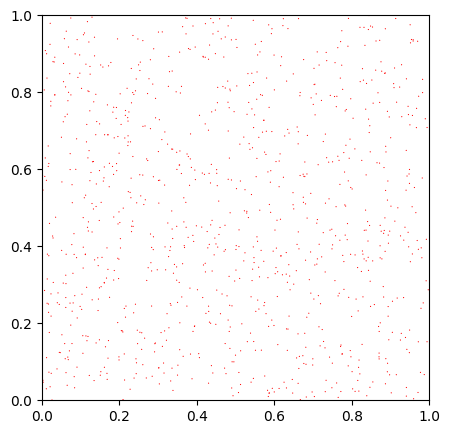

In [19]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

x, y = R[0][0], R[0][1]
circles = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(x,y)]
cred = matplotlib.collections.PatchCollection(circles, facecolors='red')
ax.add_collection(cred)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

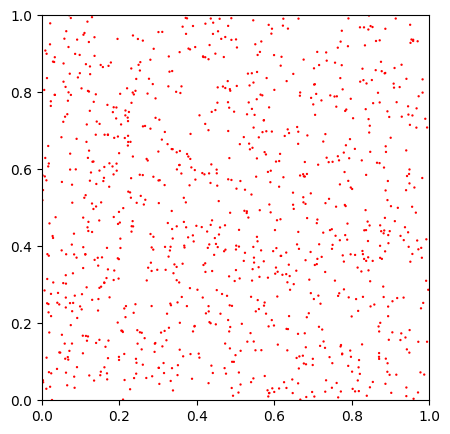

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

def animate(i):
    ax.clear()
    x, y = R[i][0], R[i][1]
    circles = [plt.Circle((xi, yi), radius=2*radius, linewidth=0) for xi,yi in zip(x,y)]
    cred = matplotlib.collections.PatchCollection(circles, facecolors='red')
    ax.add_collection(cred)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('kinetic_gas2.gif', writer = 'pillow', fps=30, dpi = 100)

# Epilógus

### Hasznos anyagok:

- Dokumentációk
    - Python hivatalos dokumentációja: https://docs.python.org/3/
    - [PEP 8](https://peps.python.org/pep-0008/) Style Guide for Python Code - Melyek a jó és rossz programozási praktikák
    - NumPy hivatalos dokumentációja: https://numpy.org/doc/1.25/
- Tankönyvek
    - [Dive Into Python 3](http://diveintopython3.problemsolving.io/)
    - [Dive into Deep Learning](https://d2l.ai/) - Interaktív tankönyv Deep Learninghez
    - [Fluent Python: Clear, Concise, and Effective Programming by Luciano Ramalho](https://www.oreilly.com/library/view/fluent-python/9781491946237/) - Haladóbb szemléletű Python programozás
- Útmutatók
    - [The Official Python Tutorial](https://docs.python.org/3/tutorial/) - Self-explanatory?
    - [Foglalt Keyword lista](https://docs.python.org/3.0/reference/lexical_analysis.html#id8) - Ezeket ne használd változónévnek!
    - [Codecademy](https://www.codecademy.com/catalog) - Interaktív (fizetős) online tutorial
    - [CheckIO](https://py.checkio.org/) - Tanulj Pythont játékfejlesztésen kersztül
- Competitive Programming
    - [Codewars](https://www.codewars.com/?language=python)
    - [CodeForces](https://codeforces.com/)

### Elérhetőség

Bármilyen kérdés, kérés vagy probléma esetén keressetek minket az alábbi elérhetőségeken:
- Monori Bence - m.bence02@outlook.hu
- Wenesz Dominik - weneszdominik@gmail.com

Illetve anonim üzenetküldésre is lehetőséget biztosítunk, ezt az alábbi linken tudjátok elérni: https://forms.gle/6VtGvhja3gq6CTT66